We must win a marketing campaign made of 2 subproblems:
1. winning the advertizing campaign using an algorithm for Truthful Auctions
2. deciding the optimal price for the product

In [129]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize
from matplotlib import cm

np.random.seed(42)

In [130]:
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)

    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)
        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

In [131]:
class Auction:
    def __init__(self, *args, **kwargs):
        pass

    def get_winners(self, bids):
        pass

    def get_payments_per_click(self, winners, values, bids):
        pass

    def round(self, bids):
        winners, values = self.get_winners(bids) # allocation mechanism!
        payments_per_click = self.get_payments_per_click(winners, values, bids)
        return winners, payments_per_click

In [132]:
class SecondPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        adv_ranking = np.argsort(values)
        second = adv_ranking[-2]

        payment = (values[second] / self.ctrs[winners]) * bids[second]
        return payment.round(2)

In [133]:
class MultiplicativePacingAgent:
    def __init__(self, valuation, budget, T, eta):
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.valuation/(self.lmbd+1)

    def update(self, f_t, c_t):

        if self.budget < 1:
            return

        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t), a_min=0, a_max=1/self.rho)

        # print(self.lmbd, self.rho)
        self.budget -= c_t

        if self.T - self.t != 0:
            self.rho = self.budget / (self.T - self.t)

        self.t += 1

In [134]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100, min_price=0, max_price=1):
        self.T = T
        self.arms = np.linspace(min_price, max_price, discretization) # here discretization is just to simplyfy calculations, but does not affect the continuity of the action set
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        self.gamma = lambda t: np.log(t+1)**2
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T)))
        self.N_pulls = np.zeros(discretization)
        self.t = 0

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

In [135]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost

    def round(self, p_t, n_t):
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t))
        r_t = (p_t - self.cost)*d_t
        return d_t, r_t

In [136]:
def get_clairvoyant_truthful(B, my_valuation, m_t, n_users):
    ## I compute my sequence of utilities at every round
    # m_t is the maximum among competing bids
    utility = (my_valuation-m_t)*(my_valuation>=m_t)
    ## Now I have to find the sequence of m_t summing up to budget B and having the maximum sum of utility
    ## In second price auctions, I can find the sequence **greedily**:
    sorted_round_utility = np.flip(np.argsort(utility)) # sorted rounds, from most profitable to less profitable

    #init to zero
    clairvoyant_utilities = np.zeros(n_users)
    clairvoyant_bids= np.zeros(n_users)
    clairvoyant_payments = np.zeros(n_users)
    c = 0 # payed so far
    i = 0
    while c <= B-1 and i < n_users:
        clairvoyant_bids[sorted_round_utility[i]] = 1
        clairvoyant_utilities[sorted_round_utility[i]] = utility[sorted_round_utility[i]]
        clairvoyant_payments[sorted_round_utility[i]] = m_t[sorted_round_utility[i]]
        c += m_t[sorted_round_utility[i]]
        i+=1
    return clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments

In [137]:
def get_competing_max_bid(n_advertisers, n_users, B):
  # a function to return m_t for each day. Simulates n_users rounds and return the maximum bid
  # Number of advertisers (including competitors)

  # competitors
  other_bids = np.clip(np.random.normal(0.55, 0.2, size = (n_advertisers-1, n_users)),0.01, 1)
  m_t = other_bids.max(axis=0)

  return m_t, other_bids

In [138]:
def conversion_probability(p):
  # Define the conversion probability function
  # the prob that a user clicks given that they see the ad
  return 1-p

In [139]:
def reward_function(price, cost, n_sales):
  return (price-cost)*n_sales

In [140]:

def simulate_purchases(price, num_users):
    """
    Simulate user purchases for a given normalized price (0 <= price <= 1) and number of users.
    Parameters:
        price (float): The normalized price of the product (0 <= price <= 1).
        num_users (int): The number of users who see the product.
    Returns:
        tuple: (conversion probability, number of purchases)
    """
    # Ensure price is within [0, 1]
    if price < 0 or price > 1:
        raise ValueError("Price must be between 0 and 1")

    # Calculate probability of purchase
    prob = conversion_probability(price)

    # Simulate purchases
    purchases = sum(np.random.binomial(1, prob) for _ in range(num_users))

    return prob, purchases

def plot_demand_curve(prices, num_users):
    """
    Plot the expected and estimated demand curves and print the demand at each price.
    Parameters:
        prices (array): Array of normalized prices from 0 to 1.
        num_users (int): Number of users to simulate.
    """
    expected_demand_curve = 1 - prices  # Expected demand is linearly decreasing with price
    estimated_demand_curve = []

    for price in prices:
        # Get expected demand at this price
        expected_demand = 1 - price

        # Simulate purchases at this price
        _, purchases = simulate_purchases(price, num_users)
        estimated_demand = purchases / num_users  # Estimate: ratio of purchases to users

        # Print expected and estimated demand at this price
        print(f"Price: {price:.2f} | Expected Demand: {expected_demand:.2f} | Estimated Demand: {estimated_demand:.2f}")

        # Append the estimated demand
        estimated_demand_curve.append(estimated_demand)

    # Plotting the curves
    plt.figure(figsize=(8, 6))
    plt.plot(prices, expected_demand_curve, label='Expected Demand Curve', linestyle='--')
    plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve', linestyle='-')
    plt.xlabel('Item Price')
    plt.ylabel('Demand Probability')
    plt.title('Expected vs Estimated Demand Curve')
    plt.legend()
    plt.show()

Running the algorithms separately

# Requirement 1

## Pricing algorithm R1
Build a pricing strategy using the continuous set of prices p ∈ [0, 1] and Gaussian Processes: Gaussian Process Upper Confidence Bound (GPUCB) strategy

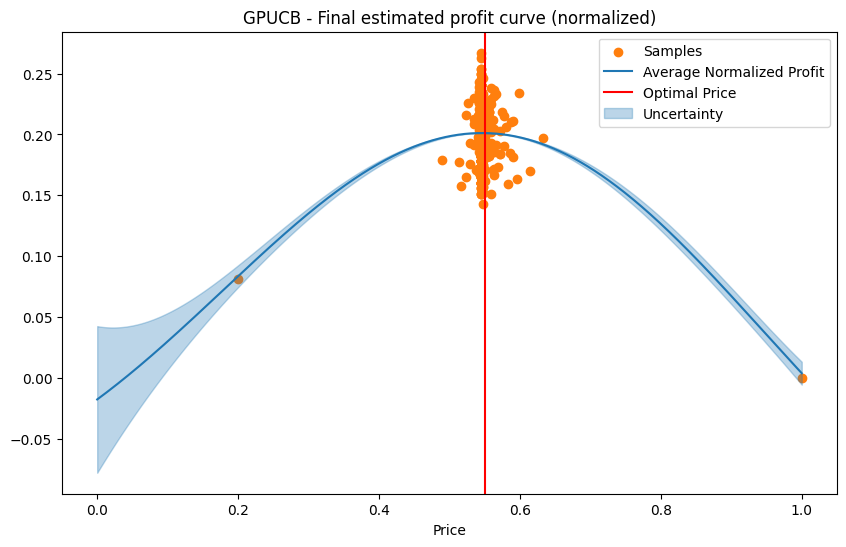

In [141]:
T = 500

min_price = 0.2
max_price = 1

n_customers = 100
cost = 0.1

agent = GPUCBAgent(T, 300, min_price, max_price)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, 1000)
profit_curve = reward_function(prices, cost, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    d_t, r_t = env.round(p_t, n_t=n_customers)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

selected_prices = agent.action_hist
selected_rewards = agent.reward_hist

gp = RBFGaussianProcess(scale=2).fit(selected_prices, selected_rewards)
mu, sigma = gp.predict(np.linspace(0,1,1000))

plt.figure(figsize=(10, 6))
plt.scatter(selected_prices, selected_rewards, label='Samples', color='C1')
plt.plot(np.linspace(0,1,1000), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,1000), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

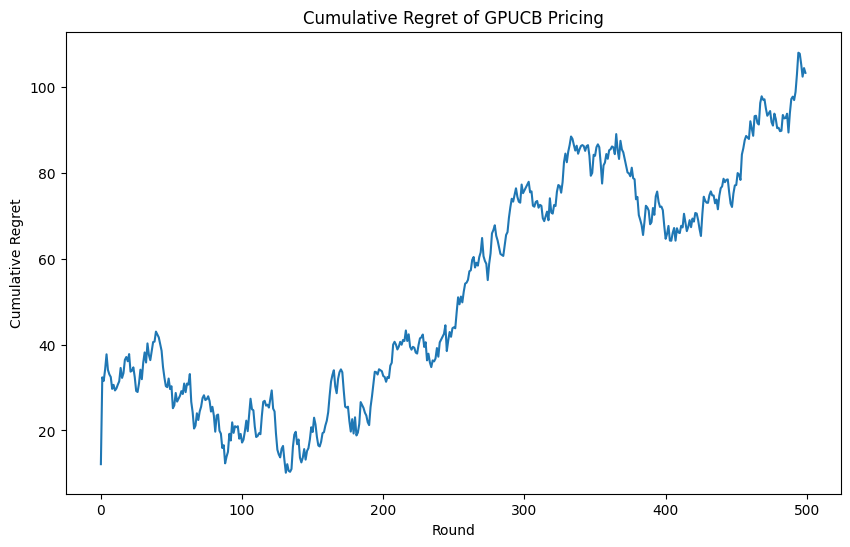

Total regret: 103.36776772621114


In [142]:
plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of GPUCB Pricing')
plt.show()

print(f"Total regret: {cumulative_regret[-1]}")

## Bidding algorithm R1
Consider a sequence of second-price auctions. Build two learning algorithms to deal with the bidding problem:
- A primal-dual algorithm for truthful auctions
- A UCB-like algorithm

In [143]:
from math import isinf
import numpy as np
from scipy.optimize import linprog
import matplotlib.pyplot as plt


import numpy as np

class UCBBiddingAgent:
    def __init__(self, budget, T, eta, rho):
        """
        Initialize the UCB Bidding Agent.

        Parameters:
        budget: Total budget B
        T: Number of rounds
        eta: Learning rate
        rho: Budget per round
        """
        self.budget = budget
        self.T = T
        self.eta = eta
        self.rho = rho
        self.t = 0
        self.B = budget
        self.gamma = 0 # all equal prob
        self.bids = []
        self.f_t = {}  # Cumulative rewards for each bid
        self.c_t = {}  # Cumulative costs for each bid
        self.N_t = {}  # Counts how many times each bid has been selected

    def initialize_bid_data(self, bid_space):
        """
        Initialize bid tracking structures.

        Parameters:
        bid_space: List of possible bids
        """
        self.bids = bid_space
        for b in bid_space:
            self.f_t[b] = 0
            self.c_t[b] = 0
            self.N_t[b] = 0

        self.gamma = np.repeat(1 / len(self.bids), len(self.bids)) # all equal prob

    def compute_ucb(self, bid):
        """
        Compute the Upper Confidence Bound (UCB) for a given bid.

        Parameters:
        bid: The bid to compute UCB for
        """
        if self.N_t[bid] == 0:
            return float('inf')  # Assign high value to unexplored bids
        mean_reward = self.f_t[bid] / self.N_t[bid]
        exploration_term = self.eta*np.sqrt(2 * np.log(self.t) / self.N_t[bid])
        return mean_reward + exploration_term

    def compute_lcb(self, bid):
        """
        Compute the Lower Confidence Bound (LCB) for a given bid.

        Parameters:
        bid: The bid to compute LCB for
        """
        if self.N_t[bid] == 0:
            return 0  # Assign low value to unexplored bids
        mean_cost = self.c_t[bid] / self.N_t[bid]
        exploration_term = self.eta*np.sqrt(2 * np.log(self.t) / self.N_t[bid])
        return mean_cost - exploration_term

    def compute_optimal_bid(self):
        """
        Solve the optimization problem to select the bid with the highest UCB,
        subject to the LCB cost constraint.

        Returns:
        Optimal bid
        """
        optimal_bid = None

        ucb_values = []
        lcb_values = []

        for bid in self.bids:
            ucb_value = self.compute_ucb(bid)
            lcb_value = np.clip(self.compute_lcb(bid), 0, 1)

            ucb_values.append(ucb_value)
            lcb_values.append(lcb_value)

        ucb_values = np.array(ucb_values)
        lcb_values = np.array(lcb_values)

        if np.inf in ucb_values or np.inf in lcb_values:
            return self.gamma

        # define linear solver parameters
        c = -1 * ucb_values.reshape(-1, 1).T
        A_ub = lcb_values.reshape(-1, 1).T
        b_ub = self.rho
        A_eq = np.ones((1, len(self.bids)))
        b_eq = [1]

        # print(c.shape, A_ub.shape, b_ub)

        res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0, 1))

        return res.x.T

    def bid(self):
        """
        Select the optimal bid for the current round.

        Returns:
        The selected bid
        """
        if self.budget < 1:
            return 0  # Terminate if budget is too low

        self.gamma = self.compute_optimal_bid()

        selected_bid = np.random.choice(a=self.bids, p=self.gamma) # random choice guided by gamma

        # print(f"{self.t}: B={self.budget:.2f}, bid={selected_bid:.2f}, UCB={self.compute_ucb(selected_bid):.2f}, LCB={self.compute_lcb(selected_bid):.2f}")

        return selected_bid

    def update(self, b_t, f_t_observed, c_t_observed):
        """
        Update agent's parameters after observing results.

        Parameters:
        b_t: Bid placed
        f_t_observed: Observed reward
        c_t_observed: Observed cost
        """
        # Update reward and cost data
        self.N_t[b_t] += 1
        self.f_t[b_t] += f_t_observed
        self.c_t[b_t] += c_t_observed

        self.t += 1

        # Update budget
        self.budget -= c_t_observed

        if self.T - self.t != 0:
            self.rho = self.budget / (self.T - self.t)

In [144]:
# Advertisers' fixed parameters
## we assume that our agent has the FIRST index

n_advertisers = 4 # four advertisers, including myself
ctrs = np.ones(n_advertisers) * 0.4

my_valuation = 0.8
B = 2000 # the budget I have for the campaign

minBid = 0.01
maxBid = 1
possible_bids = np.arange(minBid, my_valuation, minBid)

# environmental settings
n_users = 10000

m_t, other_bids = get_competing_max_bid(n_advertisers=n_advertisers, n_users=n_users, B=B)

## I'm considering competitors stronger than me, since they are free to exceed my budget
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users)

eta = 1/np.sqrt(n_users) # from theory

agent_ucb = UCBBiddingAgent(budget=B, T=n_users, eta=eta, rho=B/n_users)
agent_ucb.initialize_bid_data(possible_bids)

agent_mp = MultiplicativePacingAgent(my_valuation, B, T=n_users, eta=eta)

auction = SecondPriceAuction(ctrs)

utilities_ucb = np.array([])
utilities_mp = np.array([])


my_bids_ucb = np.array([])
my_bids_mp = np.array([])

competitor_bids = np.array([])

total_wins_ucb = 0
total_wins_mp = 0

budget_deplated_ucb = False
budget_deplated_mp = False

for u in range(n_users):
    # Interaction
    my_bid_ucb = agent_ucb.bid()
    my_bid_mp = agent_mp.bid()

    if my_bid_ucb == 0:
        budget_deplated_ucb = True
    if my_bid_mp == 0:
        budget_deplated_mp = True

    if budget_deplated_ucb and budget_deplated_mp:
        break

    bids_ucb = np.append(my_bid_ucb, other_bids[:, u].ravel())  # Combine bids with competitors' bids
    bids_mp = np.append(my_bid_mp, other_bids[:, u].ravel())  # Combine bids with competitors' bids

    winners_ucb, payments_per_click_ucb = auction.round(bids=bids_ucb)  # Perform the auction round
    winners_mp, payments_per_click_mp = auction.round(bids=bids_mp)  # Perform the auction round

    my_win_ucb = int(winners_ucb == 0)  # Check if the agent wins
    my_win_mp = int(winners_mp == 0)  # Check if the agent wins

    # if e did not won, no update
    f_t1, c_t1 = (my_valuation - m_t[u]) * my_win_ucb, m_t[u] * my_win_ucb
    if not budget_deplated_ucb:
      agent_ucb.update(my_bid_ucb, f_t1, c_t1)

    # if e did not won, no update
    f_t2, c_t2 = (my_valuation - m_t[u]) * my_win_mp, m_t[u] * my_win_mp
    if not budget_deplated_mp:
      agent_mp.update(f_t2, c_t2)

    competitor_bids = np.append(competitor_bids, np.max(other_bids[:, u]))

    # Logging
    utilities_ucb = np.append(utilities_ucb, f_t1)
    utilities_mp = np.append(utilities_mp, f_t2)

    my_bids_ucb = np.append(my_bids_ucb, my_bid_ucb)
    total_wins_ucb += my_win_ucb

    my_bids_mp = np.append(my_bids_mp, my_bid_mp)
    total_wins_mp += my_win_mp


Total # of Wins: 3525


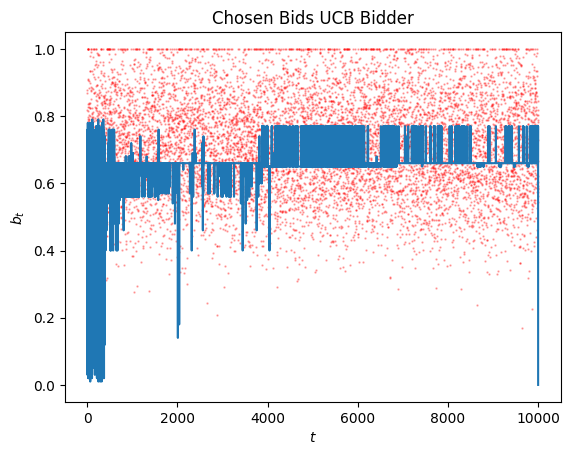

In [145]:

print(f'Total # of Wins: {total_wins_ucb}')

# Plotting chosen bids
plt.plot(my_bids_ucb)
plt.scatter(range(len(my_bids_ucb)), competitor_bids, c='r', s=0.5, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids UCB Bidder')
plt.show()

Total # of Wins: 3537


Text(0.5, 1.0, 'Chosen Bids MP Bidder')

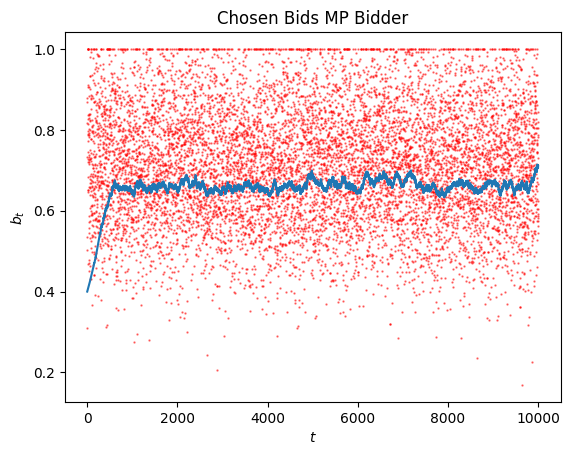

In [146]:
print(f'Total # of Wins: {total_wins_mp}')

plt.plot(my_bids_mp)
plt.scatter(range(len(my_bids_mp)), competitor_bids, c='r', s=0.5, alpha=0.5)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids MP Bidder')

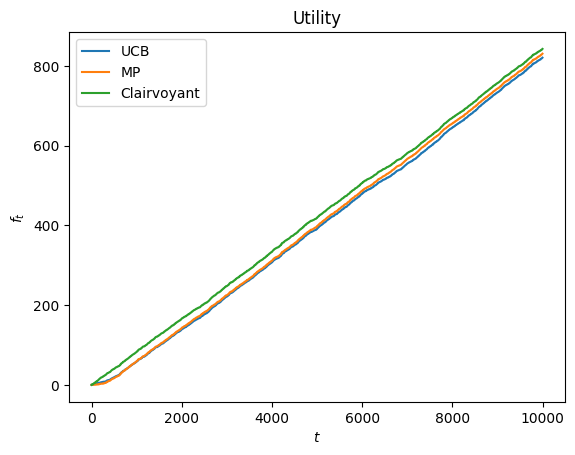

In [147]:
plt.plot(np.cumsum(utilities_ucb))
plt.plot(np.cumsum(utilities_mp))
plt.plot(np.cumsum(clairvoyant_utilities))
plt.xlabel('$t$')
plt.ylabel('$f_t$')
plt.title('Utility')
plt.legend(['UCB', 'MP', 'Clairvoyant'])
plt.show()

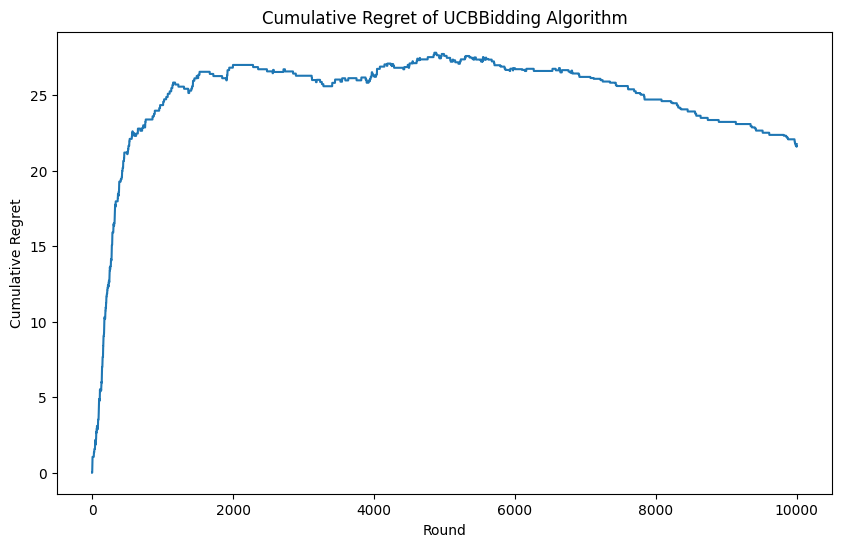

Total regret: 21.767544217784845


In [148]:
# prompt: I want to plot the regret of the UCBBidding algorithm. Also calculate this regret

import matplotlib.pyplot as plt

# Assuming 'clairvoyant_utilities' and 'utilities' are defined from the previous code

cumulative_regret = np.cumsum(clairvoyant_utilities[:len(utilities_ucb)] - utilities_ucb)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of UCBBidding Algorithm')
plt.show()

print(f"Total regret: {cumulative_regret[-1]}")

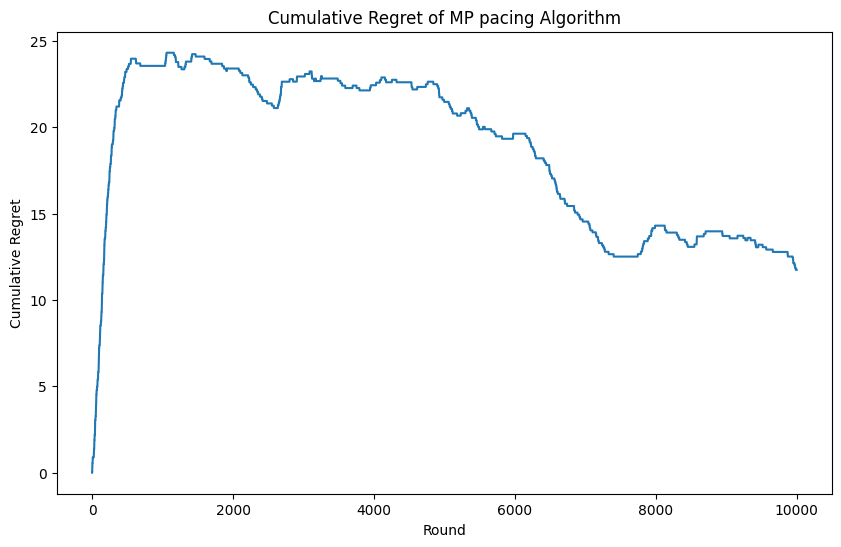

Total regret: 11.742498385312668


In [149]:
import matplotlib.pyplot as plt

# Assuming 'clairvoyant_utilities' and 'utilities' are defined from the previous code

cumulative_regret = np.cumsum(clairvoyant_utilities[:len(utilities_mp)] - utilities_mp)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of MP pacing Algorithm')
plt.show()

print(f"Total regret: {cumulative_regret[-1]}")

## Bidding + Pricing R1

At each day:
1. The company chooses a price p
2. The company faces a sequence of auctions. For each auction:
  1. The company chooses a bid b
  2. A slot is (possibly) assigned to the company depending on b, the competing bids, and the auction format
  3. If the ad is clicked, an user visit the company web page
  4. The user buy the company product with a probability that depends on the price p

In [150]:
# Problem variables
n_bidders = 4  # Competitors
ctrs = np.ones(n_bidders) * 0.74 # necessary for advertizing

# price vars
min_price = 0.3
max_price = 1
cost = 0.1

# bid vars
min_bid = 0.01
max_bid = 1
my_valuation = 0.8
possible_bids = np.arange(min_bid, my_valuation, min_bid)

# symulation vars
days = 30 # 1 month campaign
n_users = 1000 # users accessing the website each day

B = n_users * days * 2 # define campaign budget

m_t, other_bids = get_competing_max_bid(n_advertisers=n_advertisers, n_users=n_users*days, B=B)

## I'm considering competitors stronger than me, since they are free to exceed my budget
clairvoyant_bids, clairvoyant_utilities, clairvoyant_payments = get_clairvoyant_truthful(B, my_valuation, m_t, n_users*days)

# env settings
auction = SecondPriceAuction(ctrs=ctrs) # Auction env
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost) # Pricing env

# agents settings
pricing_agent = GPUCBAgent(days, 300, min_price, max_price)

eta = 1/np.sqrt(n_users*days) # from theory
advertising_agent = UCBBiddingAgent(budget=B, T=n_users*days, eta=eta, rho=B/(n_users*days))
advertising_agent.initialize_bid_data(possible_bids)

total_user_clicking = 0
utilities = np.array([])
my_bids = np.array([])
competitor_bids = np.array([])
agent_rewards = np.array([])
selected_prices = np.array([])

for d in range(days):
  p_t = pricing_agent.pull_arm() # get a price sample

  people_engaged = 0 # n. users to which the ad was shown
  # simulate n - auctions
  for u in range(n_users):
      # Interaction
      my_bid = advertising_agent.bid()

      if my_bid == 0:
          print("Budget exhausted")
          break

      bids = np.append(my_bid, other_bids[:, u + d * n_users].ravel())  # Combine bids with competitors' bids

      winners, payments_per_click = auction.round(bids=bids)  # Perform the auction round

      my_win = int(winners == 0)  # Check if the agent wins

      # if e did not won, no update
      f_t, c_t = (my_valuation - m_t[u + d * n_users]) * my_win, m_t[u + d * n_users] * my_win
      advertising_agent.update(my_bid, f_t, c_t)

      people_engaged += my_win

      my_bids = np.append(my_bids, my_bid)
      competitor_bids = np.append(competitor_bids, np.max(other_bids[:, u + d * n_users]))
      utilities = np.append(utilities, f_t)

  users_clicking = np.sum(np.random.binomial(1, ctrs[0], people_engaged))
  total_user_clicking += users_clicking

  # update environment based on purchases
  d_t, r_t = env.round(p_t, n_t=users_clicking)
  pricing_agent.update(r_t/users_clicking)

  selected_prices = np.append(selected_prices, p_t)
  agent_rewards = np.append(agent_rewards, r_t)

  print(f"Day {d}: price={p_t}, user_clicking={users_clicking}, reward={r_t}")


Day 0: price=0.3, user_clicking=282, reward=39.199999999999996
Day 1: price=1.0, user_clicking=452, reward=0.0
Day 2: price=0.6394648829431437, user_clicking=464, reward=99.26153846153845
Day 3: price=0.5528428093645485, user_clicking=449, reward=89.66287625418062
Day 4: price=0.5551839464882943, user_clicking=454, reward=91.94715719063545
Day 5: price=0.5551839464882943, user_clicking=443, reward=84.20903010033445
Day 6: price=0.5528428093645485, user_clicking=457, reward=88.75719063545152
Day 7: price=0.5551839464882943, user_clicking=453, reward=82.84347826086956
Day 8: price=0.5528428093645485, user_clicking=446, reward=89.66287625418062
Day 9: price=0.5551839464882943, user_clicking=469, reward=100.59565217391304
Day 10: price=0.5551839464882943, user_clicking=447, reward=91.94715719063545
Day 11: price=0.5551839464882943, user_clicking=432, reward=86.94013377926422
Day 12: price=0.5551839464882943, user_clicking=446, reward=93.76789297658863
Day 13: price=0.5551839464882943, user

Total number of customer clicking: 13462


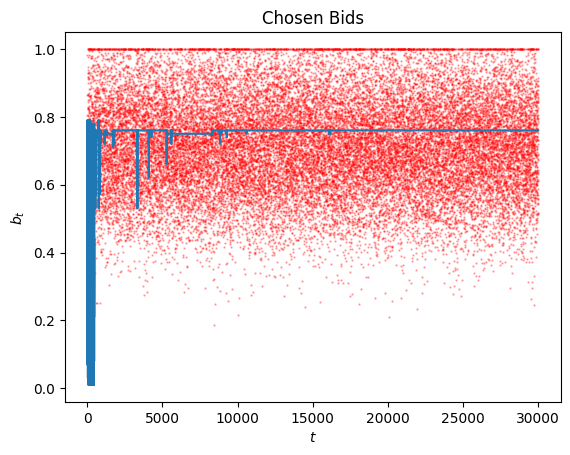

In [151]:
print(f'Total number of customer clicking: {total_user_clicking}')

# Plotting chosen bids
plt.plot(my_bids)
plt.scatter(range(len(my_bids)), competitor_bids, c='r', s=0.5, alpha=0.3)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

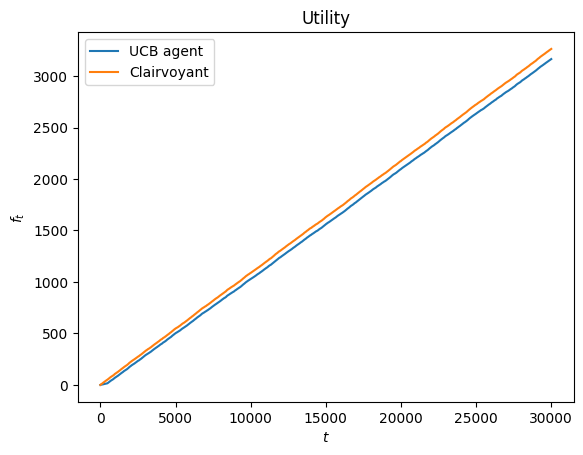

In [152]:
plt.plot(np.cumsum(utilities))
plt.plot(np.cumsum(clairvoyant_utilities))
plt.xlabel('$t$')
plt.ylabel('$f_t$')
plt.title('Utility')
plt.legend(['UCB agent', 'Clairvoyant'])
plt.show()

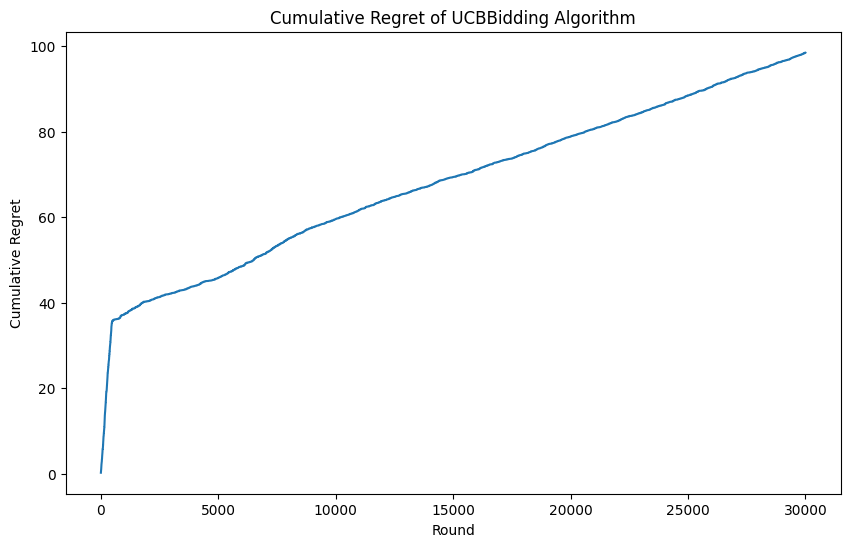

Total regret: 98.45358816659662


In [153]:
cumulative_regret = np.cumsum(clairvoyant_utilities[:len(utilities)] - utilities)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of UCBBidding Algorithm')
plt.show()

print(f"Total regret: {cumulative_regret[-1]}")

0.5501501501501501


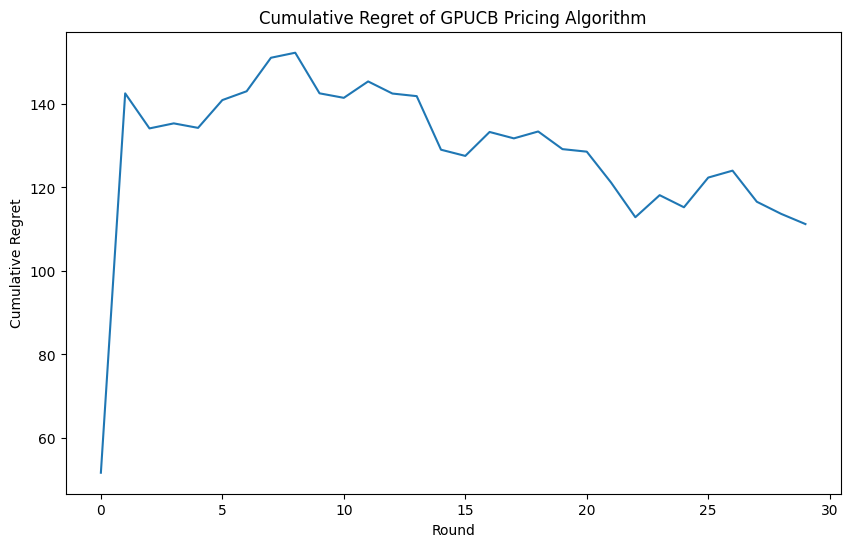

Total regret: 111.23095067890239


In [154]:
# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, 1000)
average_user_clicking = total_user_clicking / days
profit_curve = reward_function(prices, cost, average_user_clicking*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
print(best_price)
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], days)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)

plt.figure(figsize=(10, 6))
plt.plot(cumulative_regret)
plt.xlabel('Round')
plt.ylabel('Cumulative Regret')
plt.title('Cumulative Regret of GPUCB Pricing Algorithm')
plt.show()

print(f"Total regret: {cumulative_regret[-1]}")

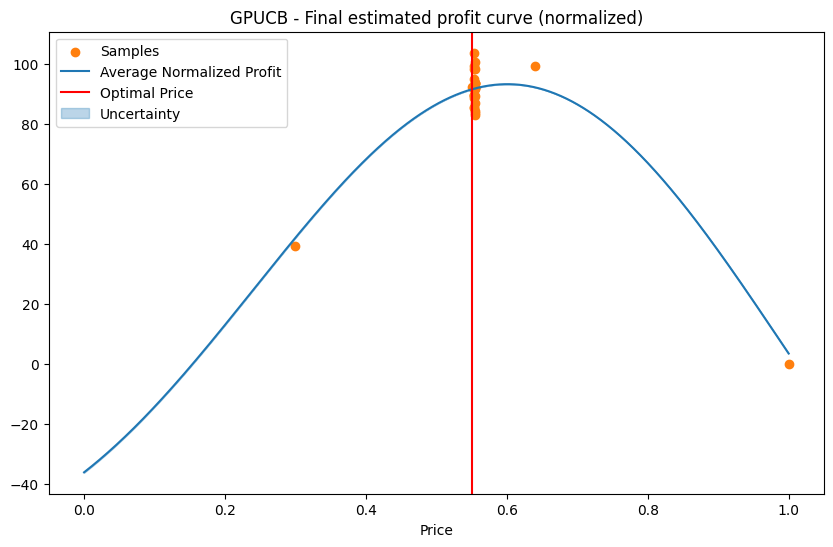

In [155]:
selected_rewards = agent_rewards
gp = RBFGaussianProcess(scale=2).fit(selected_prices, selected_rewards)
mu, sigma = gp.predict(np.linspace(0,1,1000))

plt.figure(figsize=(10, 6))
plt.scatter(selected_prices, selected_rewards, label='Samples', color='C1')
plt.plot(np.linspace(0,1,1000), mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(np.linspace(0,1,1000), mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show()

# Requirement 2

## Bidding algorithm R2

In [156]:
class FirstPriceAuction(Auction):
    def __init__(self, ctrs):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)

    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)
        winner = adv_ranking[-1]
        return winner, adv_values

    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

In [157]:
class NonstationaryBernoulliEnvironment():
    def __init__(self, mu, T, cost):
        np.random.seed(1234)
        self.mu = np.array(mu)
        self.K = mu.shape[1]
        self.cost = cost
        self.t = 0

    def round(self, a_t, p_t, n_t):
        mu_t = mu[a_t, self.t]
        d_t = np.random.binomial(n_t, p=mu_t)
        r_t = (p_t - self.cost)*d_t
        self.t +=1
        return r_t, d_t

In [158]:
def get_competing_max_bid_not_stationary(n_advertisers, n_users, B):
  # a function to return m_t for each day. Simulates n_users rounds and return the maximum bid
  # Number of advertisers (including competitors)

 # non-trivial scenario: competitors sample bids from a uniform with range varying over time
  pattern = lambda t: 1-np.abs(np.sin(5*t/n_users + 420 + 69) + np.sin(5*t/n_users + 420 + 69)*np.cos(7*t/n_users))
  other_bids = np.array([np.clip(np.random.uniform(0, pattern(t), size = n_advertisers - 1), 0.2, 1) for t in range(n_users)]).T
  # I assume that competitors may have a larger budget than mine, but they may
  # not deplete it.

  m_t = other_bids.max(axis=0)

  return m_t, other_bids

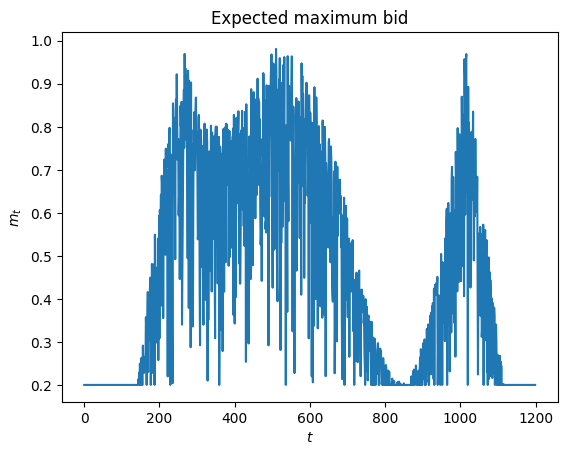

In [159]:
m_t, _ = get_competing_max_bid_not_stationary(n_advertisers=4, n_users=1200, B=45)

plt.plot(m_t)
plt.title('Expected maximum bid')
plt.xlabel('$t$')
plt.ylabel('$m_t$')
plt.show()

In [160]:
def get_clairvoyant_truthful_not_stationary(B, available_bids, my_valuation, m_t, n_users):

  rho = B/n_users
  win_probabilities = np.array([sum(b > m_t)/n_users for b in available_bids])
  ## Linear Program
  c = -(my_valuation-available_bids)*win_probabilities
  A_ub = [available_bids*win_probabilities]
  b_ub = [rho]
  A_eq = [np.ones(len(available_bids))]
  b_eq = [1]
  res = optimize.linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=(0,1))
  gamma = res.x
  expected_clairvoyant_utilities = [-res.fun for u in range(n_users)]
  expected_clairvoyant_bids = [sum(available_bids*gamma*win_probabilities) for u in range(n_users)]

  return expected_clairvoyant_bids, expected_clairvoyant_utilities, gamma

In [161]:
class HedgeAgent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.x_t = np.ones(K)/K
        self.a_t = None
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, l_t):
        self.weights *= np.exp(-self.learning_rate*l_t)
        self.t += 1

In [162]:
class EXP3Agent:
    def __init__(self, K, learning_rate):
        self.K = K
        self.learning_rate = learning_rate
        self.weights = np.ones(K)
        self.a_t = None
        self.x_t = np.ones(K)/K
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        self.x_t = self.weights/sum(self.weights)
        self.a_t = np.random.choice(np.arange(self.K), p=self.x_t)
        return self.a_t

    def update(self, r_t):
        l_t = 1 - r_t
        l_t_tilde = l_t/self.x_t[self.a_t]
        self.weights[self.a_t] *= np.exp(-self.learning_rate*l_t_tilde)
        self.N_pulls[self.a_t] += 1
        self.t += 1

In [163]:
class FFMultiplicativePacingAgent:
    def __init__(self, bids_set, valuation, budget, T, eta):
        self.bids_set = bids_set
        self.K = len(bids_set)
        self.hedge = HedgeAgent(self.K, np.sqrt(np.log(self.K)/T))
        self.valuation = valuation
        self.budget = budget
        self.eta = eta
        self.T = T
        self.rho = self.budget/self.T
        self.lmbd = 1
        self.t = 0

    def bid(self):
        if self.budget < 1:
            return 0
        return self.bids_set[self.hedge.pull_arm()]

    def update(self, f_t, c_t, m_t):
        # update hedge
        f_t_full = np.array([(self.valuation-b)*int(b >= m_t) for b in self.bids_set])
        c_t_full = np.array([b*int(b >= m_t) for b in self.bids_set])
        L = f_t_full - self.lmbd*(c_t_full-self.rho)
        range_L = 2+(1-self.rho)/self.rho
        self.hedge.update((2-L)/range_L) # hedge needs losses in [0,1]
        # update lagrangian multiplier
        self.lmbd = np.clip(self.lmbd-self.eta*(self.rho-c_t),
                            a_min=0, a_max=1/self.rho)
        # update budget
        self.budget -= c_t

In [164]:
n_users = 5000
B = 300
my_valuation = 0.4
rho = B/n_users

m_t, other_bids = get_competing_max_bid_not_stationary(n_advertisers=n_advertisers, n_users=n_users, B=B)

# bid vars
n_advertisers = 4
ctrs = np.ones(n_advertisers) # necessary for advertizing
min_bid = 0.01
max_bid = 1
possible_bids = np.arange(min_bid, my_valuation, min_bid)

expected_clairvoyant_bids, expected_clairvoyant_utilities, gamma = get_clairvoyant_truthful_not_stationary(B, possible_bids, my_valuation, m_t, n_users)

eta = 1/np.sqrt(n_users) # from theory
agent = FFMultiplicativePacingAgent(bids_set = possible_bids,
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users,
                                    eta=eta)

auction = FirstPriceAuction(np.ones(n_advertisers))

utilities = np.array([])
my_bids = np.array([])
my_payments = np.array([])
total_wins = 0

for u in range(n_users):
    # interaction
    my_bid = agent.bid()
    bids = np.append(my_bid, other_bids[:, u].ravel())
    winners, payments_per_click = auction.round(bids=bids)
    my_win = int(winners==0)
    f_t, c_t = (my_valuation-my_bid)*my_win, my_bid*my_win
    agent.update(f_t, c_t, m_t[u])
    # logging
    utilities = np.append(utilities, f_t)
    my_bids = np.append(my_bids, my_bid)
    my_payments = np.append(my_payments, c_t)
    total_wins+=my_win
print(f'Total # of Wins: {total_wins}')

Total # of Wins: 847


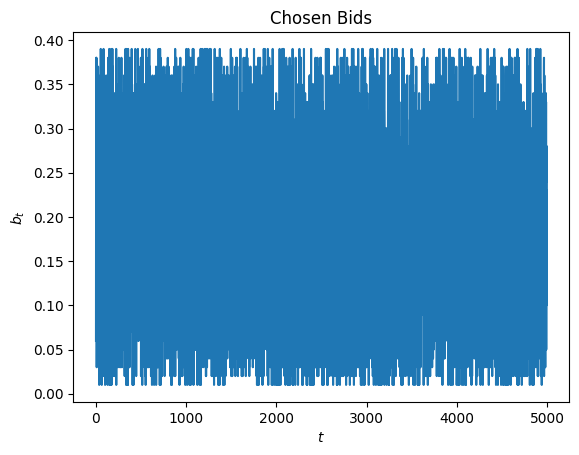

In [165]:
plt.plot(my_bids)
plt.xlabel('$t$')
plt.ylabel('$b_t$')
plt.title('Chosen Bids')
plt.show()

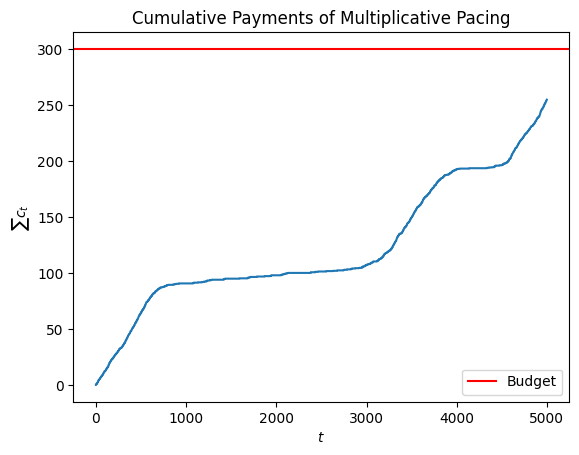

In [166]:
cumulative_payments = np.cumsum(my_payments)
plt.plot(cumulative_payments)
plt.xlabel('$t$')
plt.ylabel('$\sum c_t$')
plt.axhline(B, color='red', label='Budget')
plt.legend()
plt.title('Cumulative Payments of Multiplicative Pacing')
plt.show()

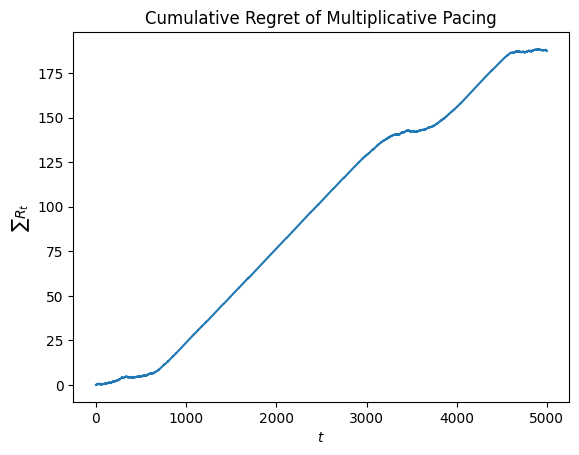

In [167]:
cumulative_regret = np.cumsum(expected_clairvoyant_utilities-utilities)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret of Multiplicative Pacing')
plt.show()

In [168]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K # discretized action set
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

In [169]:
def conversion_probability_non_stationary(p, T):
  return np.clip(np.abs(np.random.normal(p, 0.01) * np.sin(2*T)), 0, 1)

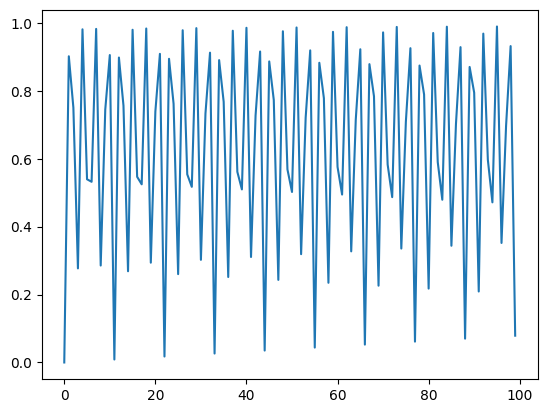

In [170]:
plt.plot(conversion_probability_non_stationary(0.99, np.arange(100)))

## Pricing algorithm R2

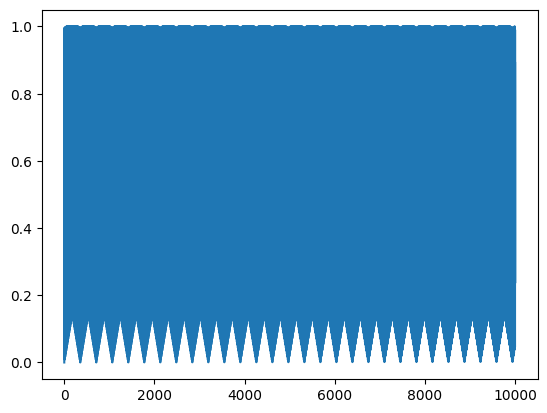

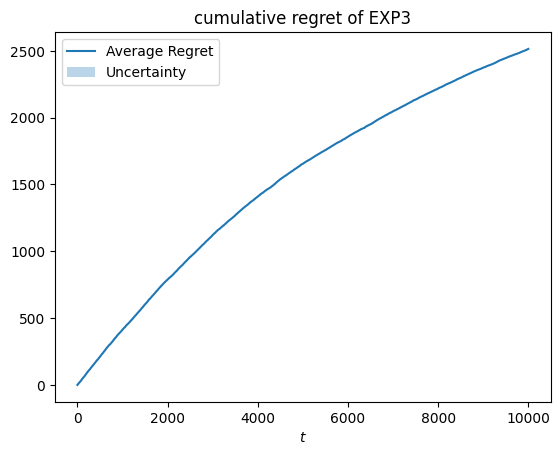

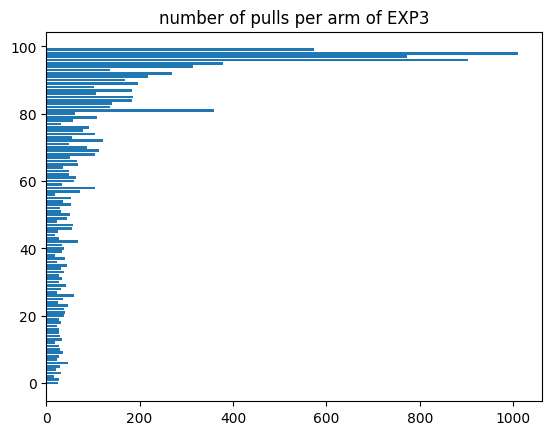

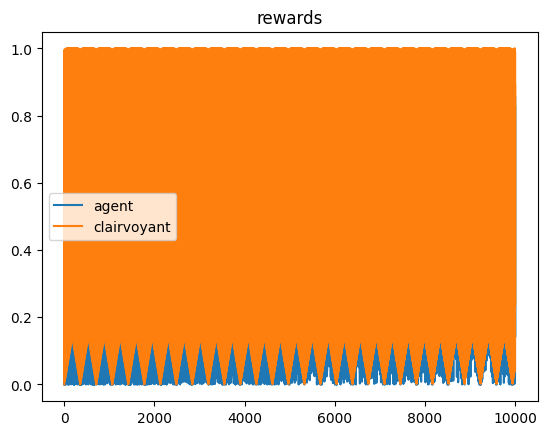

In [171]:
T = 10000 # try T=100, why this behavior?
K = 100

prices = np.linspace(0.1,1,K) # 100 actions!
cost = 0.1

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

maximum_profit = reward_function(max(prices),cost, n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

mu = np.zeros((K, T))
for i in range(K):
  mu[i, :] = conversion_probability_non_stationary(prices[i], np.arange(T))

# let's compute the clairvoyant
expected_clairvoyant_rewards = np.array(mu).max(axis=0)
plt.plot(expected_clairvoyant_rewards)
plt.figure()

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, cost)
    # K = env.rewards
    learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)
    agent = EXP3Agent(K, learning_rate)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t]
        r_t, d_t = env.round(pi_t, p_t, n_customers)
        agent.update(r_t/n_customers)

        agent_rewards = np.append(agent_rewards, r_t/n_customers)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of EXP3')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()
plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.title('number of pulls per arm of EXP3')
plt.show()
plt.figure()
plt.plot(agent_rewards, label='agent')
plt.plot(expected_clairvoyant_rewards, label='clairvoyant')
plt.legend()
plt.title('rewards')
plt.show()

In [172]:
print(np.max(agent.N_pulls))
print(prices[np.argmax(agent.N_pulls)])

1011.0
0.9909090909090909


## Bidding + Pricing R2


In [173]:
# Problem variables
n_bidders = 4  # Competitors
ctrs = np.ones(n_bidders) * 0.74 # necessary for advertizing

# bid vars
min_bid = 0.01
max_bid = 1
my_valuation = 0.9
K=5 # we assume 100 actions
possible_bids = np.arange(min_bid, my_valuation, min_bid)

# price vars
min_price = 0.3
max_price = 1
cost = 0.1
prices = np.linspace(min_price,max_price,K) # 100 actions!

# symulation vars
days = 200 # 1 month campaign
n_users = 1000 # users accessing the website each day

mu = np.zeros((K, days))
for i in range(K):
  mu[i, :] = conversion_probability_non_stationary(prices[i], np.arange(days))

# let's compute the clairvoyant
expected_clairvoyant_rewards = np.array(mu).max(axis=0)

B = n_users * days * 2 # define campaign budget

m_t, other_bids = get_competing_max_bid_not_stationary(n_advertisers=n_advertisers, n_users=n_users*days, B=B)

## I'm considering competitors stronger than me, since they are free to exceed my budget
expected_clairvoyant_bids, expected_clairvoyant_utilities, gamma = get_clairvoyant_truthful_not_stationary(B, possible_bids, my_valuation, m_t, n_users*days)

# env settings
auction = FirstPriceAuction(ctrs=ctrs) # Auction env
env = NonstationaryBernoulliEnvironment(mu, days, cost)

# agents settings
maximum_profit = reward_function(max(prices),cost, n_users*days) # the maximum possible reward is selling at the maximum price to every possible customer

learning_rate = np.sqrt(np.log(K)/(K*T)) # we set the learning rate as prescribed by the theory (different from expert setting)
pricing_agent = EXP3Agent(K, learning_rate)

eta = 1/np.sqrt(n_users*days) # from theory
advertising_agent = agent = FFMultiplicativePacingAgent(bids_set = possible_bids,
                                    valuation=my_valuation,
                                    budget=B,
                                    T=n_users*days,
                                    eta=eta)

total_user_clicking = 0
utilities = np.array([])
my_bids = np.array([])
competitor_bids = np.array([])
agent_rewards = np.array([])
selected_prices = np.array([])

for d in range(days):
  p_i = pricing_agent.pull_arm() # get a price sample

  p_t = prices[p_i] # get the actual price


  people_engaged = 0 # n. users to which the ad was shown
  # simulate n - auctions
  for u in range(n_users):
      # Interaction
      my_bid = advertising_agent.bid()

      if my_bid == 0:
          print("Budget exhausted")
          break

      bids = np.append(my_bid, other_bids[:, u + d * n_users].ravel())  # Combine bids with competitors' bids

      winners, payments_per_click = auction.round(bids=bids)  # Perform the auction round

      my_win = int(winners == 0)  # Check if the agent wins

      # if e did not won, no update
      f_t, c_t = (my_valuation - my_bid) * my_win, my_bid * my_win
      advertising_agent.update(f_t, c_t, m_t[u + d * n_users])

      people_engaged += my_win

      my_bids = np.append(my_bids, my_bid)
      competitor_bids = np.append(competitor_bids, np.max(other_bids[:, u + d * n_users]))
      utilities = np.append(utilities, f_t)

  users_clicking = np.sum(np.random.binomial(1, ctrs[0], people_engaged))
  total_user_clicking += users_clicking

  # update environment based on purchases
  r_t, d_t = env.round(p_i, p_t, n_t=users_clicking)
  if users_clicking != 0:
    pricing_agent.update(r_t/users_clicking)
  else:
    pricing_agent.update(r_t)

  selected_prices = np.append(selected_prices, p_t)
  agent_rewards = np.append(agent_rewards, r_t/users_clicking)

  print(f"Day {d}: price={p_t},people_engaged={people_engaged} user_clicking={users_clicking}, reward={r_t/users_clicking}")


Day 0: price=0.3,people_engaged=835 user_clicking=622, reward=0.0
Day 1: price=0.475,people_engaged=911 user_clicking=682, reward=0.1743035190615836
Day 2: price=0.475,people_engaged=907 user_clicking=676, reward=0.13313609467455623
Day 3: price=0.6499999999999999,people_engaged=901 user_clicking=665, reward=0.10172932330827067
Day 4: price=0.6499999999999999,people_engaged=848 user_clicking=618, reward=0.3461974110032362
Day 5: price=0.825,people_engaged=847 user_clicking=634, reward=0.3327681388012618
Day 6: price=0.825,people_engaged=806 user_clicking=592, reward=0.3159628378378378
Day 7: price=0.3,people_engaged=786 user_clicking=575, reward=0.058086956521739126
Day 8: price=0.825,people_engaged=780 user_clicking=573, reward=0.1657504363001745
Day 9: price=0.3,people_engaged=727 user_clicking=549, reward=0.04699453551912568
Day 10: price=0.475,people_engaged=696 user_clicking=504, reward=0.14657738095238096
Day 11: price=0.475,people_engaged=691 user_clicking=512, reward=0.00219726

Text(0.5, 1.0, 'Cumulative Regret EXP3 Agent')

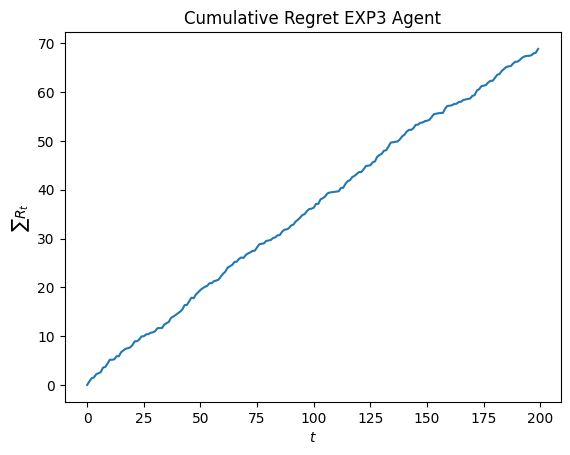

In [174]:
cumulative_regret = np.cumsum(expected_clairvoyant_rewards - agent_rewards)
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title('Cumulative Regret EXP3 Agent')

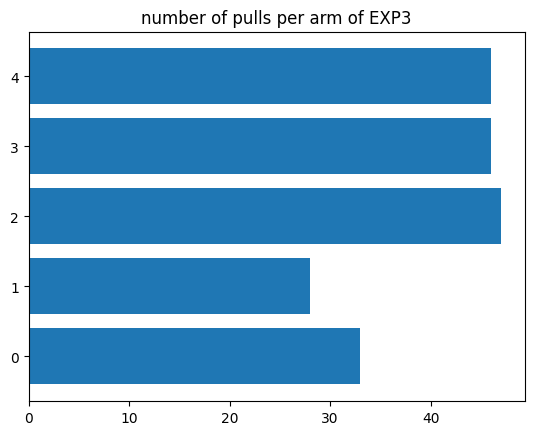

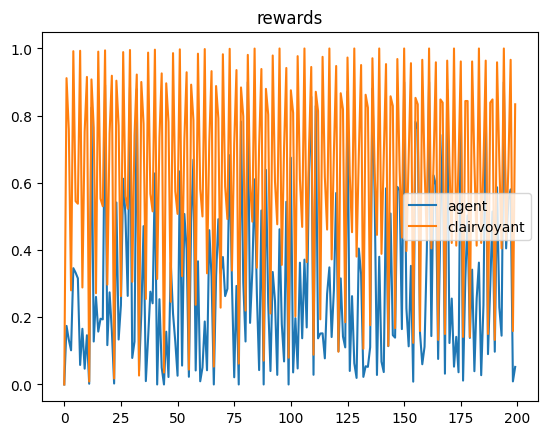

In [175]:
plt.figure()
plt.barh(np.arange(K), pricing_agent.N_pulls)
plt.title('number of pulls per arm of EXP3')
plt.show()
plt.figure()
plt.plot(agent_rewards, label='agent')
plt.plot(expected_clairvoyant_rewards, label='clairvoyant')
plt.legend()
plt.title('rewards')
plt.show()

# R3


In [176]:
class CUSUMUCBAgent:
    def __init__(self, K, T, M, h, alpha=0.99, range=1):
        self.K = K
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.a_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0

    def pull_arm(self):
        if (self.counters > 0).any():
            for a in np.arange(self.K):
                if self.counters[a] > 0:
                    self.counters[a] -= 1
                    self.a_t = a
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.a_t = np.argmax(ucbs)
            else:
                self.a_t = np.random.choice(np.arange(self.K)) # extra exploration
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.all_rewards[self.a_t].append(r_t)
        if self.counters[self.a_t] == 0:
            if self.change_detection():
                self.n_resets[self.a_t] +=1
                self.N_pulls[self.a_t] = 0
                self.average_rewards[self.a_t] = 0
                self.counters[self.a_t] = self.M
                self.all_rewards[self.a_t] = []
                self.reset_times[self.a_t] = self.t
            else:
                self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1

    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.a_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.a_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.a_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False


In [177]:
class SWUCBAgent:
    def __init__(self, K, T, W, range=1):
        self.K = K
        self.T = T
        self.W = W
        self.range = range
        self.a_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_pulls = np.zeros(K)
        self.t = 0

    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            avg_last_w = np.nanmean(self.cache, axis=0)
            ucbs = avg_last_w + self.range*np.sqrt(2*np.log(self.W)/n_pulls_last_w) # there's a typo in the slides, log(T) -> log(W)
            self.a_t = np.argmax(ucbs)
        return self.a_t

    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0) # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.a_t] = r_t
        self.cache = np.vstack((self.cache, new_samples)) # add new observation
        self.t += 1

In [178]:
def demand(K, interval, int_len):
  noise = np.random.normal(0, 0.005, size=(int_len))

  if interval == 0:
    return np.array([0.3] * int_len + noise)
  elif interval == 1:
    return np.array([0.4] * int_len + noise)
  elif interval == 2:
    return np.array([0.37] * int_len + noise)
  elif interval == 3:
    return np.array([0.6] * int_len + noise)
  elif interval == 4:
    return np.array([0.7] * int_len + noise)
  else:
    return np.array([0.5] * int_len + noise)

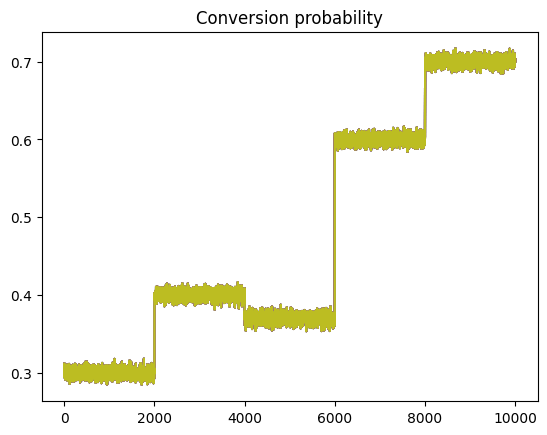

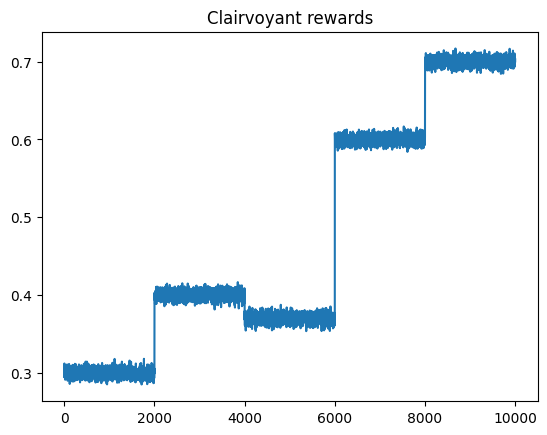

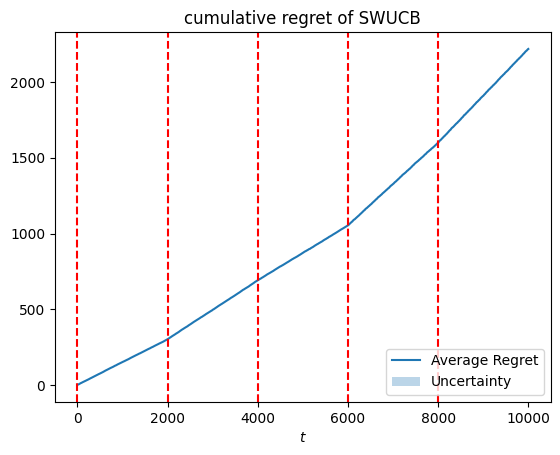

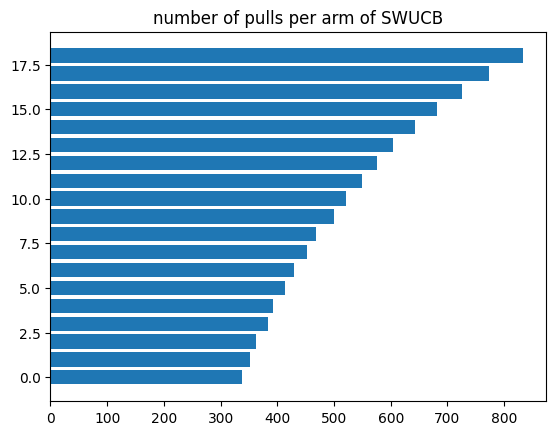

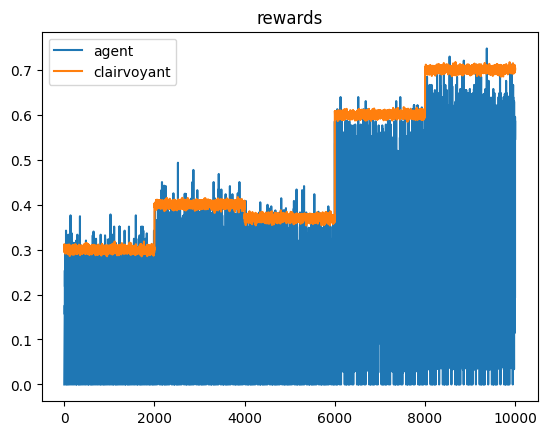

In [179]:
T = 10000 # try T=100, why this behavior?
K = int(0.9 * T**(1/3)) # From theory

prices = np.linspace(0.1,1,K) # 100 actions!
cost = 0.1

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)
n_intervals = 5

maximum_profit = reward_function(max(prices),cost, n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

mu = np.zeros((K, T))
for j in range(n_intervals):
  mu[:, j*T//n_intervals:(j+1)*T//n_intervals] = demand(K, j, T//5)

plt.plot(mu.T)
plt.title('Conversion probability')
plt.show()

W = int(2*np.sqrt(T*np.log(T)/n_intervals)) # assuming n_intervals is known

# let's compute the clairvoyant
expected_clairvoyant_rewards = np.array(mu).max(axis=0)
plt.plot(expected_clairvoyant_rewards)
plt.title('Clairvoyant rewards')
plt.figure()

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, cost)
    # K = env.rewards
    agent = SWUCBAgent(K, T, W)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t]
        r_t, d_t = env.round(pi_t, p_t, n_customers)
        agent.update(r_t/n_customers)

        agent_rewards = np.append(agent_rewards, r_t/n_customers)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of SWUCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
for i in range(n_intervals):
    plt.axvline(i*T/n_intervals, color='red', linestyle='--')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()
plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.title('number of pulls per arm of SWUCB')
plt.show()
plt.figure()
plt.plot(agent_rewards, label='agent')
plt.plot(expected_clairvoyant_rewards, label='clairvoyant')
plt.legend()
plt.title('rewards')
plt.show()

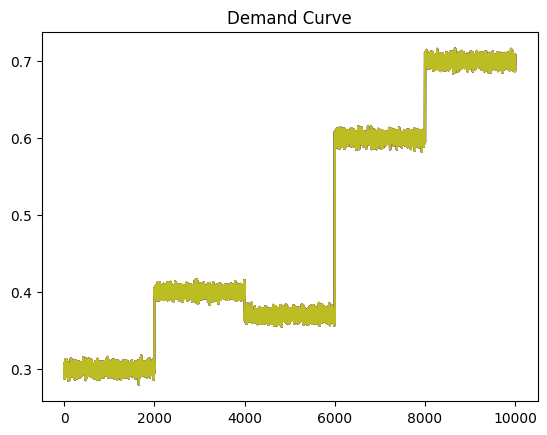

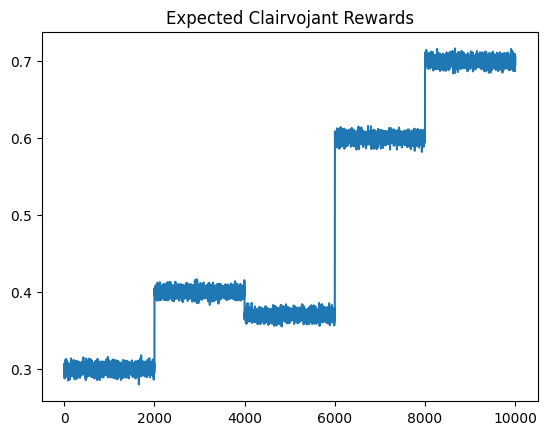

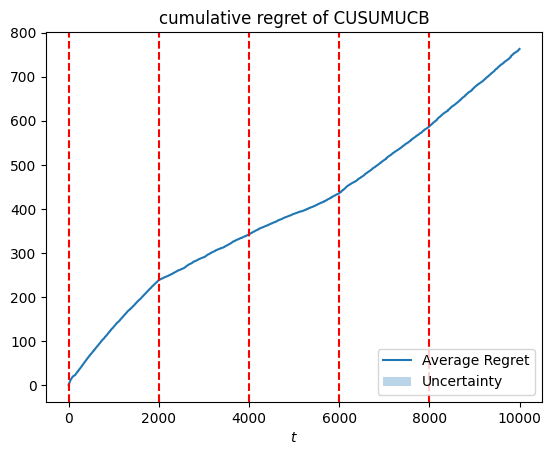

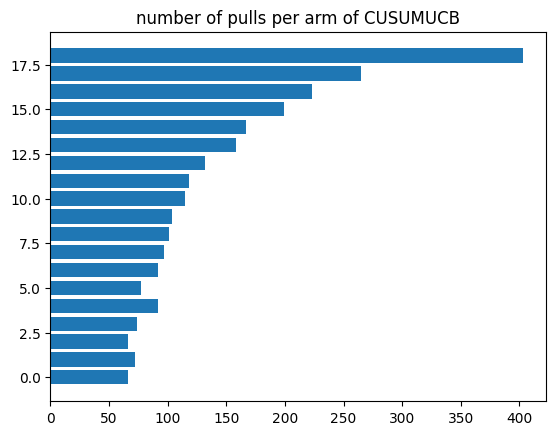

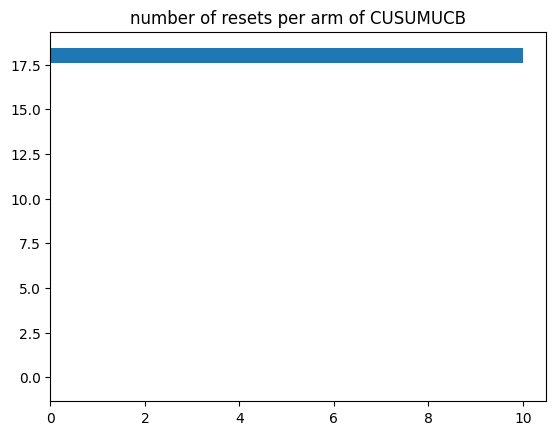

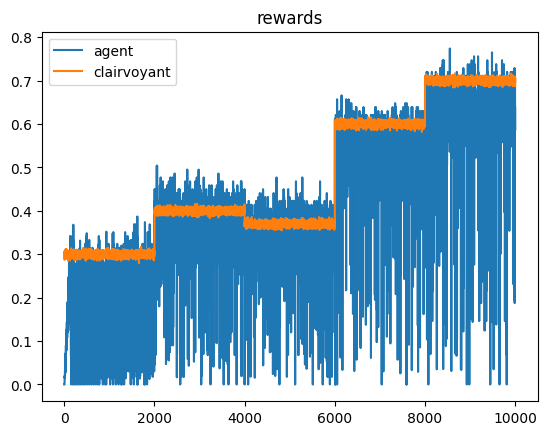

In [180]:
T = 10000 # try T=100, why this behavior?
K = int(0.9 * T**(1/3)) # From theory

prices = np.linspace(0.1,1,K) # 100 actions!
cost = 0.1

n_customers = 100 # I assume the number of customers arriving is the same everyday (for now, in general this is not true)
n_intervals = 5

maximum_profit = reward_function(max(prices),cost, n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

mu = np.zeros((K, T))
for j in range(n_intervals):
  mu[:, j*T//n_intervals:(j+1)*T//n_intervals] = demand(K, j, T//5)

plt.plot(mu.T)
plt.title('Demand Curve')
plt.show()

h = 2*np.log(T/n_intervals) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(n_intervals*np.log(T/n_intervals)/T) # probability of extra exploration

M = int(np.log(T/n_intervals)) # robustness of change detection

# let's compute the clairvoyant
expected_clairvoyant_rewards = np.array(mu).max(axis=0)
plt.plot(expected_clairvoyant_rewards)
plt.title('Expected Clairvojant Rewards')
plt.figure()

n_trials = 10

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = NonstationaryBernoulliEnvironment(mu, T, cost)
    # K = env.rewards
    agent = CUSUMUCBAgent(K, T, M, h, alpha)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t]
        r_t, d_t = env.round(pi_t, p_t, n_customers)
        agent.update(r_t/n_customers)

        agent_rewards = np.append(agent_rewards, r_t/n_customers)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of CUSUMUCB')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
for i in range(n_intervals):
    plt.axvline(i*T/n_intervals, color='red', linestyle='--')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()
plt.figure()
plt.barh(np.arange(K), agent.N_pulls)
plt.title('number of pulls per arm of CUSUMUCB')
plt.show()
plt.figure()
plt.barh(np.arange(K), agent.n_resets)
plt.title('number of resets per arm of CUSUMUCB')
plt.show()
plt.figure()
plt.plot(agent_rewards, label='agent')
plt.plot(expected_clairvoyant_rewards, label='clairvoyant')
plt.legend()
plt.title('rewards')
plt.show()

## R3 - Bonus Points

In [181]:
class DoublePricingEnvironment:
    def __init__(self, conversion_probabilities, costs):
        self.conversion_probability0 = conversion_probabilities[0] # for first item
        self.conversion_probability1 = conversion_probabilities[1] #for second item
        self.cost0 = costs[0] # cost for item i
        self.cost1 = costs[1]

    def round(self, p_ts, n_t):
        p_t0 = p_ts[0]
        p_t1 = p_ts[1]

        d_t0 = np.random.binomial(n_t, self.conversion_probability0(p_t0, p_t1))
        r_t0 = (p_t0 - self.cost0)*d_t0

        d_t1 = np.random.binomial(n_t, self.conversion_probability1(p_t0, p_t1))
        r_t1 = (p_t1 - self.cost1)*d_t1

        rewards = r_t0 + r_t1
        
        return (d_t0, d_t1), rewards       #return demand and reward


In [182]:
def conversion_probability_stochastic1(p1, p2):
  ## Given the prices of the two items, generate a 2D curve
  x = (p1-p2)
  x = 1/np.sqrt(np.pi*2) * np.exp(-1/2*(x-0.5)**2) * np.log(1/p1)
  return x

def conversion_probability_stochastic2(p2, p1):
  ## Given the prices of the two items, generate a 2D curve
  x = (p1-p2)
  x = 1/np.sqrt(np.pi*2) * np.exp(-1/2*(x-0.5)**2) * np.log(1/p1)
  return x

In [183]:
import numpy as np

class DoubleRBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale
        self.reg = reg
        self.k_xx_inv = np.array([]).reshape(0, 0)
        self.x = np.array([]).reshape(0, 2)  # Initialize x (price) as an empty 2D array
        self.y = np.array([]).reshape(0, 1)  # Initialize y (reward) 

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        output = -1 * np.ones((a.shape[0], b.shape[0]))
        for i in range(a.shape[0]):
            output[i, :] = np.power(np.linalg.norm(a[i] - b, axis=1), 2)
        return np.exp(-self.scale * output)

    
    def fit(self, x=np.array([]), y=np.array([])):
        x, y = np.array(x), np.array(y)

        B = self.rbf_kernel(self.x, x)
        self.x = np.vstack((self.x, x))
        self.y = np.vstack((self.y, y))
        self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()


        
##### Define the agent:
class DoubleGPUCBAgent:
    def __init__(self, T, discretization, minPrices, maxPrices):
        self.T = T
        self.discretization = discretization
        self.minPrices = minPrices
        self.maxPrices = maxPrices
        self.discretizedPrices = [np.linspace(minPrices, maxPrices, discretization) for i in range(2)]
        self.arms = self.discretizedPrices[0]
        grid = np.linspace(minPrices, maxPrices, discretization)
        self.arms = np.array(np.meshgrid(grid, grid)).T.reshape(-1, 2)
        self.gp = DoubleRBFGaussianProcess(scale=2)
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros((discretization, discretization))
        self.sigma_t = np.zeros((discretization, discretization))
        self.ucbs_t = np.zeros((discretization, discretization))
        self.gamma = lambda t: np.log(t + 1) ** 2
        self.beta = lambda t: 1 + 0.5 * np.sqrt(2 * (self.gamma(t) + 1 + np.log(t)))
        self.nPulls = np.zeros(self.arms.shape)
        self.t = 1

    def pull_arm(self):
        self.mu_t, self.sigma_t = self.gp.predict(self.arms)
        self.ucbs_t = self.mu_t + self.beta(self.t) * self.sigma_t
        self.a_t = np.argmax(self.ucbs_t)
        return self.arms[self.a_t]

    def update(self, r_t):
        self.nPulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        
        # Ensure r_t is reshaped to a 2D column vector with shape (1, 1)
        r_t = np.array(r_t).reshape(-1, 1)  # This ensures r_t has shape (1, 1)
    
        # Now call fit with consistent shapes
        self.gp.fit(self.arms[self.a_t].reshape(1, 2), r_t)
        self.t += 1


    def getEstimatedRewardMean(self):
        return self.ucbs_t

In [187]:
T = 80

min_price, max_price = 0.2, 1
discretization = 100
n_customers = 100
costs = np.array([0.1, 0.1])

agent = DoubleGPUCBAgent(T, discretization, min_price, max_price) # must be adapted
env = DoublePricingEnvironment(conversion_probabilities=np.array([conversion_probability_stochastic1, conversion_probability_stochastic2]), costs=costs)

# let's compute the clairvoyant
prices_i1 = np.linspace(min_price, max_price, discretization)
prices_i2 = np.linspace(min_price, max_price, discretization)

profit_curve = np.zeros((discretization, discretization))
for i in range(discretization):
  for j in range(discretization):
    p1 = prices_i1[i]
    p2 = prices_i2[j]
      
    profit_curve[i, j] = n_customers * ((np.array([p1, p2]) - costs) @ np.array([conversion_probability_stochastic1(p1, p2), conversion_probability_stochastic2(p1, p2)]))

max prices  0.4585858585858586 0.4585858585858586
max reward  19.68441691118339


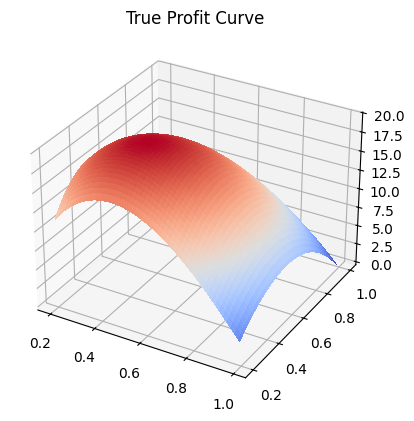

In [188]:
index_p_i1, index_p_i2 = np.unravel_index(np.argmax(profit_curve), profit_curve.shape)
print("max prices ", prices_i1[index_p_i1], prices_i2[index_p_i2])
print("max reward ", profit_curve[(index_p_i1, index_p_i2)])
expected_clairvoyant_rewards = np.repeat(profit_curve[(index_p_i1, index_p_i2)], T)

X = np.arange(min_price, max_price, (max_price - min_price) / discretization)
Y = np.arange(min_price, max_price, (max_price - min_price) / discretization)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, profit_curve, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.title("True Profit Curve")
plt.show()

Prices at day 0: [0.2 0.2]  rewards 12.4
Prices at day 1: [1. 1.]  rewards 0.0
Prices at day 2: [0.2 1. ]  rewards 2.8000000000000003
Prices at day 3: [1.  0.2]  rewards 3.1
Prices at day 4: [0.58787879 0.58787879]  rewards 19.515151515151516
Prices at day 5: [0.58787879 0.2       ]  rewards 14.945454545454545
Prices at day 6: [0.2        0.57979798]  rewards 14.355555555555556
Prices at day 7: [1.        0.5959596]  rewards 8.431313131313132
Prices at day 8: [0.5959596 1.       ]  rewards 5.951515151515153
Prices at day 9: [0.45050505 0.43434343]  rewards 17.70909090909091
Prices at day 10: [0.66060606 0.48282828]  rewards 17.77474747474748
Prices at day 11: [0.48282828 0.62020202]  rewards 13.790909090909091
Prices at day 12: [0.4989899 0.4020202]  rewards 14.031313131313134
Prices at day 13: [0.69292929 0.51515152]  rewards 20.51818181818182
Prices at day 14: [0.69292929 0.51515152]  rewards 22.416161616161617
Prices at day 15: [0.7010101  0.52323232]  rewards 17.792929292929294
Pri

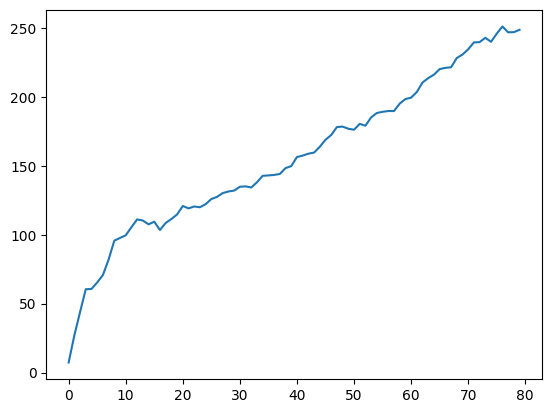

In [189]:
agent_rewards = np.array([])
for t in range(T):
    p_ts = agent.pull_arm()
    d_ts, r_ts = env.round(p_ts, n_t=n_customers) #return an array (demands) and a reward
    print("Prices at day " + str(t) + ": " + str(p_ts), " rewards " + str(r_ts))
    agent.update((r_ts/n_customers)) 
    agent_rewards = np.append(agent_rewards, r_ts) 

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

plt.plot(cumulative_regret)
plt.show()

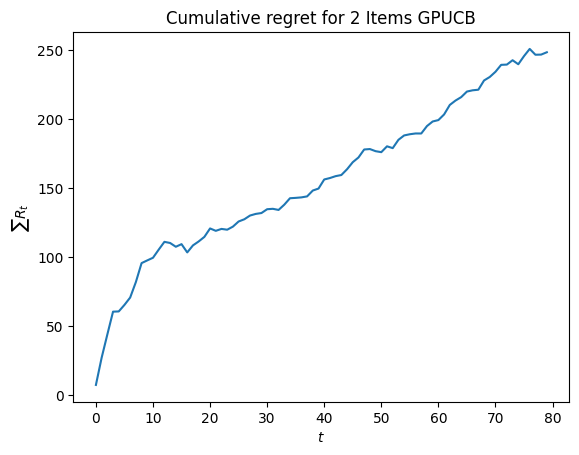

In [191]:
plt.plot(cumulative_regret)
plt.xlabel('$t$')
plt.ylabel('$\sum R_t$')
plt.title(f'Cumulative regret for 2 Items GPUCB')
plt.show()

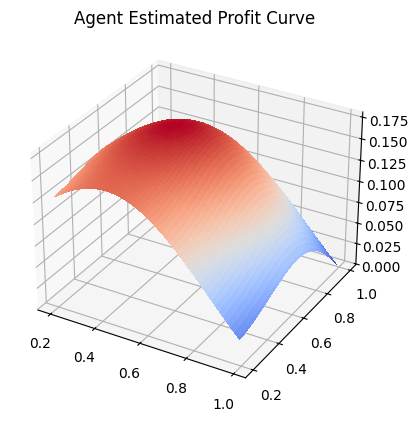

In [192]:
mu = agent.mu_t

mu = mu.reshape(discretization, discretization)

X = np.arange(min_price, max_price, (max_price - min_price) / discretization)
Y = np.arange(min_price, max_price, (max_price - min_price) / discretization)
X, Y = np.meshgrid(X, Y)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.plot_surface(X, Y, mu, cmap=cm.coolwarm, linewidth=0, antialiased=False)
plt.title("Agent Estimated Profit Curve")
plt.show()

# R4 - Bidding in Generalized First Price Auction

In [193]:
class GeneralizedFirstPriceAuction(Auction):
    def __init__(self, ctrs, n_slots):
        self.ctrs = ctrs
        self.n_adv = len(self.ctrs)
        self.n_slots = n_slots
    def get_winners(self, bids):
        adv_values = self.ctrs*bids
        adv_ranking = np.argsort(adv_values)[::-1]
        winners = adv_ranking[:self.n_slots]
        return winners, adv_values[:self.n_slots]

    def get_payments_per_click(self, winners, values, bids):
        payment = bids[winners]
        return payment.round(2)

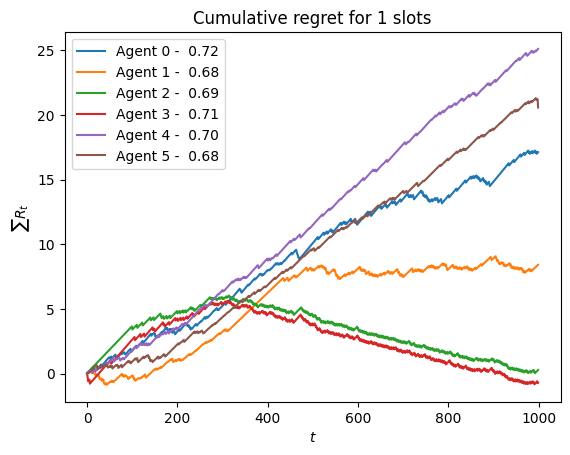

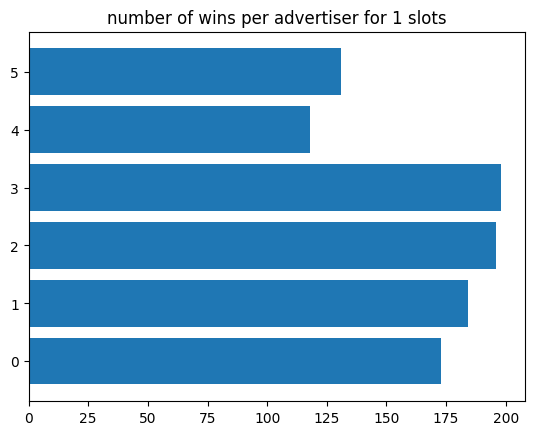

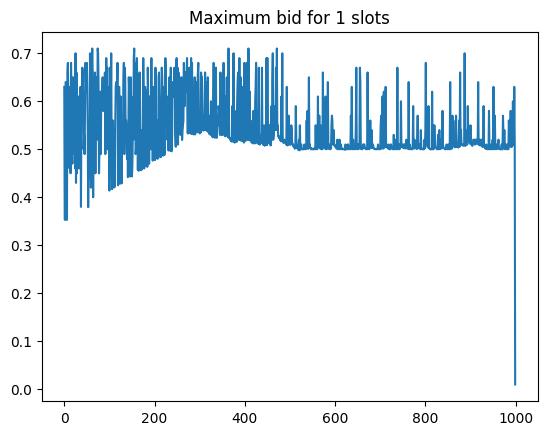

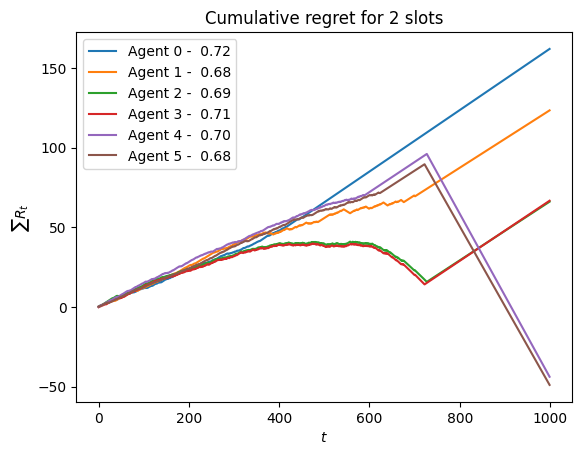

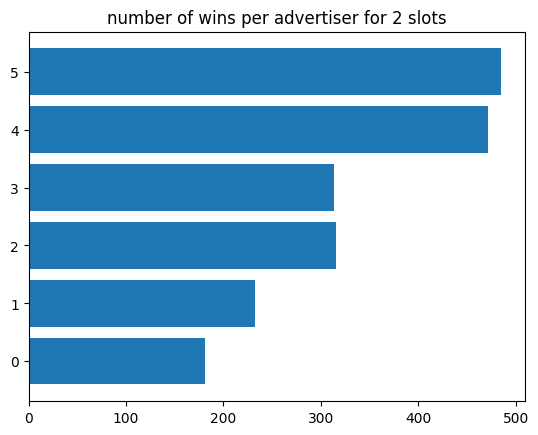

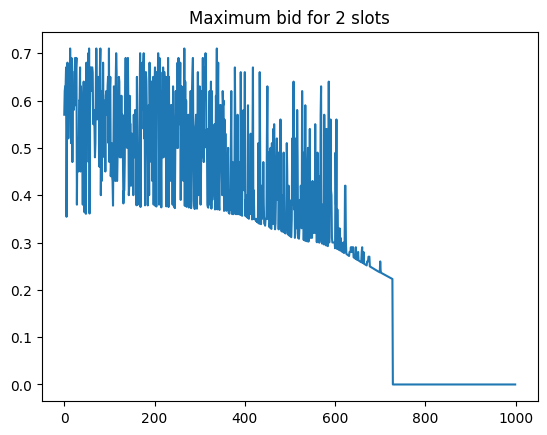

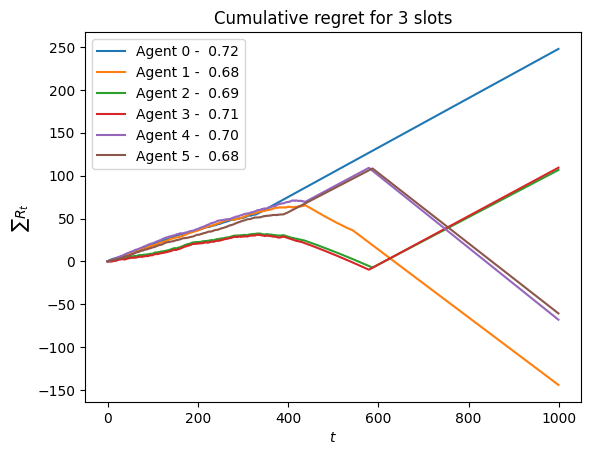

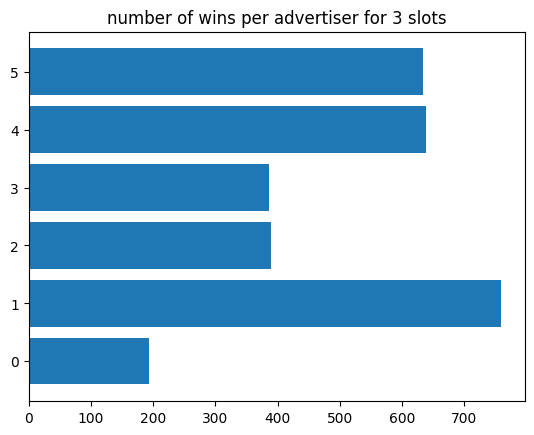

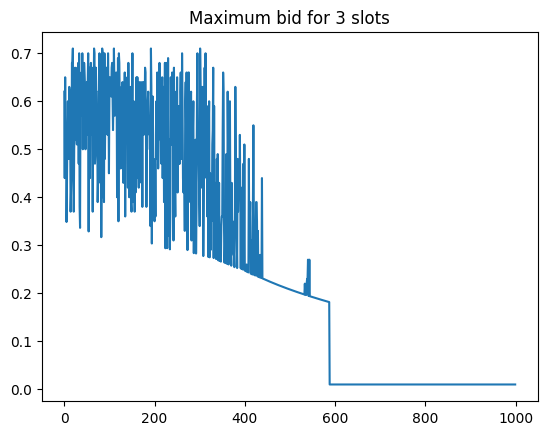

In [194]:
n_advertisers = 6
valuations = np.random.normal(0.7, 0.02, size=n_advertisers)
# valuations = np.ones(n_advertisers) * 0.65
ctrs = np.ones(n_advertisers) * 0.5
# ctrs = np.random.rand(n_advertisers)

n_slots_max = 3
B = 100 # the budget I have for the campaign

minBid = 0.01
maxBid = 1
possible_bids = np.arange(minBid, my_valuation, minBid)

# environmental settings
n_users = 1000

for n_slots in range(1, n_slots_max+1):
  # define the auction
  auction = GeneralizedFirstPriceAuction(ctrs=ctrs, n_slots=n_slots) # Auction env


  # Agent 1
  agent1 = UCBBiddingAgent(budget=B, T=n_users, eta=eta, rho=B/n_users)
  agent1.initialize_bid_data(np.arange(minBid, valuations[0], minBid))

  # Agent 2
  agent2 = UCBBiddingAgent(budget=B, T=n_users, eta=eta, rho=B/n_users)
  agent2.initialize_bid_data(np.arange(minBid, valuations[1], minBid))

  eta = 1/np.sqrt(n_users) # from theory

  # Agent 3
  agent3 = MultiplicativePacingAgent(valuations[2], B, T=n_users, eta=eta)

  # Agent 4
  agent4 = MultiplicativePacingAgent(valuations[3], B, T=n_users, eta=eta)

  # Agent 5
  agent5 = FFMultiplicativePacingAgent(bids_set = np.arange(minBid, valuations[4], minBid),
                                      valuation=valuations[4],
                                      budget=B,
                                      T=n_users,
                                      eta=eta)
  # Agent 6
  agent6 = FFMultiplicativePacingAgent(bids_set = np.arange(minBid, valuations[5], minBid),
                                      valuation=valuations[5],
                                      budget=B,
                                      T=n_users,
                                      eta=eta)

  agents = [agent1, agent2, agent3, agent4, agent5, agent6]

  utilities = np.zeros(shape=(n_advertisers, n_users))
  bids_history = np.zeros(shape=(n_advertisers, n_users))
  my_payments = np.zeros(shape=(n_advertisers, n_users))
  total_wins = np.zeros(n_advertisers)

  for u in range(n_users):
      # interaction
      bids = np.array([agent.bid() for agent in agents])
      # print(bids)
      winners, payments_per_click = auction.round(bids=bids)

      for i in range(len(agents)):
        agent_winning = int(i in winners)
        f_t, c_t = (valuations[i]-bids[i]) * agent_winning, bids[i] * agent_winning

        if bids[i] > 0:
          if i < 2:
              # UCB agent
              agents[i].update(bids[i], f_t, c_t)
          elif i>=2 and i<4:
              # PACING agent
              agents[i].update(f_t, c_t)
          else:
              # FF PACING agent
              agents[i].update(f_t, c_t, np.max(bids))

        utilities[i, u] = f_t
        bids_history[i, u] = bids[i]
        my_payments[i, u] = c_t
        total_wins[i]+=agent_winning

  m_t = np.max(bids_history, axis=0)
  # my_valuation = np.max(valuations) # track the agent more likely to win

  plt.figure()
  for i in range(n_advertisers):
    expected_clairvoyant_bids, expected_clairvoyant_utilities, gamma = get_clairvoyant_truthful_not_stationary(B, possible_bids, valuations[i], m_t, n_users)
    cumulative_regret = np.cumsum(expected_clairvoyant_utilities - utilities[i, :])
    plt.plot(cumulative_regret, label=f'Agent {i} - {valuations[i]: .2f}')

  plt.legend()
  plt.xlabel('$t$')
  plt.ylabel('$\sum R_t$')
  plt.title(f'Cumulative regret for {n_slots} slots')
  plt.show()

  plt.figure()
  plt.barh(np.arange(n_advertisers), total_wins)
  plt.title(f'number of wins per advertiser for {n_slots} slots')
  plt.show()

  plt.figure()
  plt.plot(m_t)
  plt.title(f'Maximum bid for {n_slots} slots')
  plt.show()